# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [35]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


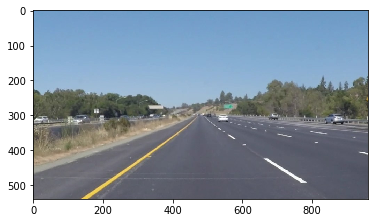

In [36]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [45]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope_threshold = .4
    left_side_x = []
    left_side_y = []
    right_side_x = []
    right_side_y = []
    height = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1 - y2) / (x1 - x2)
            if slope > slope_threshold:
                left_side_x.extend((x1, x2))
                left_side_y.extend((y1, y2))
            if slope < -slope_threshold: 
                right_side_x.extend((x1, x2))
                right_side_y.extend((y1, y2))
                
    height.extend((img.shape[0], min(left_side_y + right_side_y)))
    
    left = np.polyfit(left_side_y, left_side_x, 1)
    right = np.polyfit(right_side_y, right_side_x, 1)
    
    left_line = np.poly1d(left)
    right_line = np.poly1d(right)
    
    left_bottom = int(left_line(height[0]))
    left_top = int(left_line(height[1]))
    right_bottom = int(right_line(height[0]))
    right_top = int(right_line(height[1]))

    cv2.line(img,(left_bottom,height[0]),(left_top,height[1]),color,thickness)
    cv2.line(img,(right_bottom,height[0]),(right_top,height[1]),color,thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

In [46]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Lane Finding Pipeline
Start with copying our image to make modifications

In [47]:
filtered_image = np.copy(image)

## Grayscale
Convert to grayscale to make filtering more simple

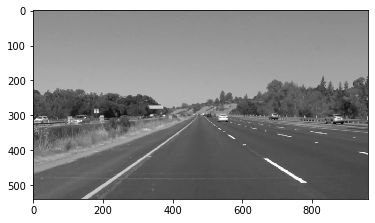

In [48]:
# Convert to grayscale
gray_image = grayscale(filtered_image)
plt.imshow(gray_image, cmap = 'gray')

## Gaussian Blur
Use a blur to filter out noise 

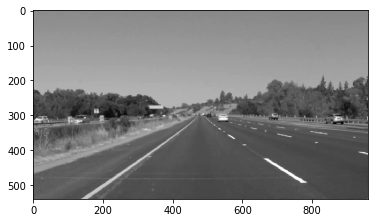

In [49]:
# Guassian Blur to average out image
kernal_size = 5
gaussian_image = gaussian_blur(gray_image, kernal_size)
plt.imshow(gaussian_image, cmap = 'gray')

## Canny Edges 
Find edges (high slopes of color change)

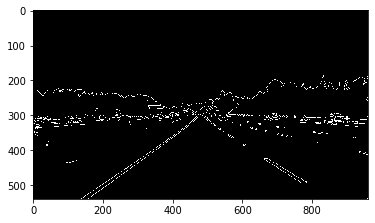

In [50]:
# Canny Edges
low_threshold = 50
high_threshold = 150
canny_image = cv2.Canny(gaussian_image, low_threshold, high_threshold)
plt.imshow(canny_image, cmap = 'gray')

## Region of Intrest
Concentrate only on our lane by creating a region defined by points in the image

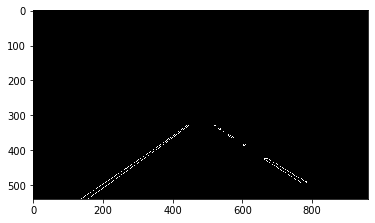

In [51]:
# ROI
# Get Sizes of image
y_size = image.shape[0]
x_size = image.shape[1]

# Define points
left_bottom = (120, y_size)
right_bottom = (x_size - 50, y_size)
left_top = (x_size / 2 - 50, y_size / 2 + 60)
right_top = (x_size / 2 + 50, y_size / 2 + 60)

# Get vertices to create a polygon of roi
vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
roi_image = region_of_interest(canny_image, vertices)
plt.imshow(roi_image, cmap = 'gray')

## Hough Lines
Highlight lines with the correct hough with the given parameters

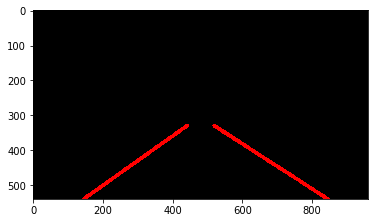

In [52]:
# Hough Lines

# parameters 
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
intersection_thresh = 10 # minimum number of votes (intersections in Hough grid cell)
min_length = 10 # minimum number of pixels making up a line
max_gap = 10 # maximum gap in pixels between connectable line segments

lines_image = hough_lines(roi_image, rho, theta, intersection_thresh, min_length, max_gap)
plt.imshow(lines_image, cmap = 'gray')

## Final Result

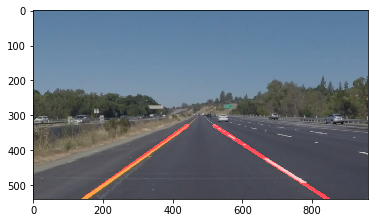

In [53]:
# Final Result
result_image = weighted_img(lines_image, image, α=0.8, β=1., γ=0.)
plt.imshow(result_image, cmap = 'gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [54]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [55]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Get Sizes of image
    y_size = image.shape[0]
    x_size = image.shape[1]
    filtered_image = np.copy(image)

    # Convert to grayscale
    gray_image = grayscale(filtered_image)

    # Guassian Blur to average out image
    kernal_size = 5
    gaussian_image = gaussian_blur(gray_image, kernal_size)

    # Canny Edges
    low_threshold = 50
    high_threshold = 150
    canny_image = cv2.Canny(gaussian_image, low_threshold, high_threshold)

    # ROI
    # Define points
    left_bottom = (120, y_size)
    right_bottom = (x_size - 40, y_size)
    left_top = (x_size / 2 - 50, y_size / 2 + 60)
    right_top = (x_size / 2 + 50, y_size / 2 + 60)

    # Get vertices to create a polygon of roi
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    roi_image = region_of_interest(canny_image, vertices)

    # Hough Lines

    # parameters 
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    intersection_thresh = 10 # minimum number of votes (intersections in Hough grid cell)
    min_length = 10 # minimum number of pixels making up a line
    max_gap = 10 # maximum gap in pixels between connectable line segments

    lines_image = hough_lines(roi_image, rho, theta, intersection_thresh, min_length, max_gap)
    plt.imshow(lines_image, cmap = 'gray')

    # Final Result
    result_image = weighted_img(lines_image, image, α=0.8, β=1., γ=0.)

    return result_image

Let's try the one with the solid white lane on the right first ...

                                                             
t:  35%|███▌      | 78/221 [57:35<00:03, 41.36it/s, now=None]
                                                             
t:  35%|███▌      | 78/221 [54:06<00:04, 32.69it/s, now=None]

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4





t:   3%|▎         | 6/221 [00:00<00:04, 48.23it/s, now=None]

t:   5%|▍         | 11/221 [00:00<00:04, 46.64it/s, now=None]

t:   7%|▋         | 15/221 [00:00<00:04, 44.03it/s, now=None]

t:   9%|▉         | 20/221 [00:00<00:04, 43.20it/s, now=None]

t:  11%|█         | 24/221 [00:00<00:04, 41.12it/s, now=None]

t:  13%|█▎        | 29/221 [00:00<00:04, 41.33it/s, now=None]

t:  15%|█▌        | 34/221 [00:00<00:04, 41.64it/s, now=None]

t:  18%|█▊        | 39/221 [00:00<00:04, 41.61it/s, now=None]

t:  19%|█▉        | 43/221 [00:01<00:04, 39.91it/s, now=None]

t:  21%|██▏       | 47/221 [00:01<00:04, 38.09it/s, now=None]

t:  23%|██▎       | 51/221 [00:01<00:05, 31.30it/s, now=None]

t:  25%|██▍       | 55/221 [00:01<00:05, 32.67it/s, now=None]

t:  27%|██▋       | 59/221 [00:01<00:04, 33.69it/s, now=None]

t:  29%|██▊       | 63/221 [00:01<00:04, 34.51it/s, now=None]

t:  30%|███       | 67/221 [00:01<00:04, 34.88it/s, now=None]

t:  32%|███▏      | 71/221 [00:01<00:04, 34.96it/s, no

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 5.01 s, sys: 490 ms, total: 5.49 s
Wall time: 7.25 s


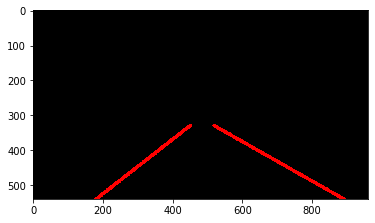

In [56]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

                                                             
t:  35%|███▌      | 78/221 [1:09:37<00:03, 41.36it/s, now=None]
                                                               
t:  35%|███▌      | 78/221 [1:06:08<00:04, 32.69it/s, now=None]

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4





t:   1%|          | 6/681 [00:00<00:13, 49.50it/s, now=None]

t:   1%|▏         | 10/681 [00:00<00:14, 45.22it/s, now=None]

t:   2%|▏         | 15/681 [00:00<00:15, 44.19it/s, now=None]

t:   3%|▎         | 19/681 [00:00<00:15, 41.92it/s, now=None]

t:   3%|▎         | 23/681 [00:00<00:15, 41.15it/s, now=None]

t:   4%|▍         | 27/681 [00:00<00:16, 40.08it/s, now=None]

t:   5%|▍         | 32/681 [00:00<00:15, 40.57it/s, now=None]

t:   5%|▌         | 37/681 [00:00<00:15, 41.00it/s, now=None]

t:   6%|▌         | 41/681 [00:01<00:15, 40.54it/s, now=None]

t:   7%|▋         | 45/681 [00:01<00:16, 39.50it/s, now=None]

t:   7%|▋         | 49/681 [00:01<00:18, 34.43it/s, now=None]

t:   8%|▊         | 53/681 [00:01<00:18, 34.81it/s, now=None]

t:   8%|▊         | 57/681 [00:01<00:17, 34.95it/s, now=None]

t:   9%|▉         | 61/681 [00:01<00:17, 35.08it/s, now=None]

t:  10%|▉         | 65/681 [00:01<00:17, 35.79it/s, now=None]

t:  10%|█         | 69/681 [00:01<00:17, 35.53it/s, no

t:  68%|██████▊   | 462/681 [00:14<00:07, 30.13it/s, now=None]

t:  68%|██████▊   | 466/681 [00:14<00:07, 29.85it/s, now=None]

t:  69%|██████▉   | 470/681 [00:14<00:06, 30.79it/s, now=None]

t:  70%|██████▉   | 474/681 [00:14<00:06, 30.58it/s, now=None]

t:  70%|███████   | 478/681 [00:14<00:06, 30.83it/s, now=None]

t:  71%|███████   | 482/681 [00:15<00:06, 30.18it/s, now=None]

t:  71%|███████▏  | 486/681 [00:15<00:06, 30.52it/s, now=None]

t:  72%|███████▏  | 490/681 [00:15<00:06, 29.74it/s, now=None]

t:  72%|███████▏  | 493/681 [00:15<00:06, 29.02it/s, now=None]

t:  73%|███████▎  | 496/681 [00:15<00:06, 28.60it/s, now=None]

t:  73%|███████▎  | 500/681 [00:15<00:06, 29.42it/s, now=None]

t:  74%|███████▍  | 504/681 [00:15<00:05, 29.83it/s, now=None]

t:  75%|███████▍  | 508/681 [00:15<00:05, 30.54it/s, now=None]

t:  75%|███████▌  | 512/681 [00:16<00:05, 29.70it/s, now=None]

t:  76%|███████▌  | 515/681 [00:16<00:05, 28.37it/s, now=None]

t:  76%|███████▌  | 518/681 [00:16<00:05

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 16.2 s, sys: 1.76 s, total: 18 s
Wall time: 22.7 s


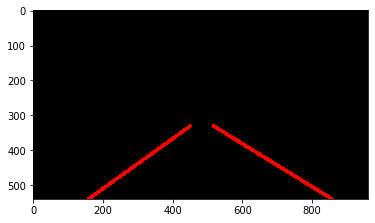

In [61]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflection

### Pipeline as shown above:
    1. Grayscale - to simplify image processing
    2. Gaussian Blur - to remove noise
    3. Canny edges - to get lane line markings
    4. ROI - to remove excess noise and focus on lanes
    5. Hough Lines - fit lines with correct slopes to average 2 lane markings
    
draw_lines function:
    A draw lines function was created for the hough lines step in order to create straight line markings for the video. I used a for loop to process each line that was returned by the canny function. This returned a set of points for each line which could be converted into slopes using the slope formula. I used a slope_threshold to divide them into either a left lane or a right lane. The lines were then averaged and extrapolated using the polyfit and poly1d functions which created a fitted line. The function then returns these two fitted lines, one for the left lane and one for the right lane.

### Potential shortcomings and possible approaches

One potential shortcoming would be if we introduce curving lane lines or the image gets distorted to make it appear so. My functions are tuned for straight lines at the moment. In order to account for more curvy lines I would have to modify my draw lines function in order to fit lines to a higher degree or to possibly break the canny lines into shorter line segments to account for curves.
